# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.preprocessing import scale

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
#from xgboost.sklearn import XGBClassifier  
#from xgboost.sklearn import XGBRegressor
#from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting
#import xgboost as xgb

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from time import time

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Dataset Azdias

In [3]:
azdias.head()
print(azdias.shape)

(891221, 366)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
# Count NaNs in each column in azdias
df_a_1 = pd.DataFrame(azdias.isnull().sum()/azdias.shape[0])
df_a_1.head()

,0
LNR,0.000000
AGER_TYP,0.000000
AKT_DAT_KL,0.082470
ALTER_HH,0.082470
ALTER_KIND1,0.909048


In [6]:
# Check columns which have more than 90% nan cells.
azdias_null_cols = list(df_a_1[df_a_1[0] > 0.9].index) 
print(len(azdias_null_cols),"\n",azdias_null_cols)

4 
 ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']


Dataset Customers

In [7]:
customers.head()
print(customers.shape)

(191652, 369)


In [8]:
# customers.describe()

In [9]:
attribute_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx').drop('Unnamed: 0', axis=1)

In [10]:
attribute_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [11]:
# Count nan in each column in customers.
df_c_1 = pd.DataFrame(customers.isnull().sum()/customers.shape[0])
df_c_1.head()

,0
LNR,0.000000
AGER_TYP,0.000000
AKT_DAT_KL,0.243128
ALTER_HH,0.243128
ALTER_KIND1,0.938607


In [12]:
# Check columns which have more than 90% nan cells.
customers_null_cols = list(df_c_1[df_c_1[0]>0.9].index) 
print(len(customers_null_cols),"\n",customers_null_cols)

4 
 ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4']


In [13]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


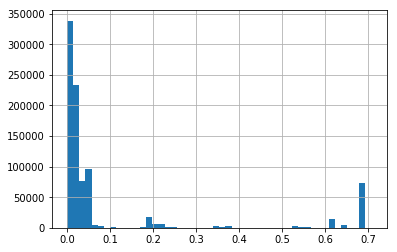

In [14]:
# Count NaNs in each rows in azdias
df_a_2 =pd.DataFrame(azdias.isnull().sum(axis=1)/azdias.shape[1])
df_a_2[0].hist(bins=50);

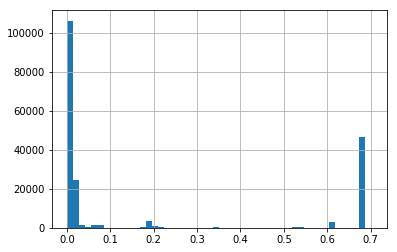

In [15]:
# Count NaNs in each rows in customers
df_c_2 =pd.DataFrame(customers.isnull().sum(axis=1)/customers.shape[1])
df_c_2[0].hist(bins=50);

In [16]:
# Choose some columns where there are no or few missing values
df_c_2.sort_values(0,ascending=True).head(50)

,0
147415,0.0
31764,0.0
65236,0.0
77669,0.0
172811,0.0
126541,0.0
51625,0.0
65758,0.0
51454,0.0
5587,0.0


In [17]:
# Choose some columns where there are no or few missing values
df_a_2.sort_values(0,ascending=True).head(50)

,0
301178,0.0
829956,0.0
730037,0.0
763105,0.0
66430,0.0
791473,0.0
299382,0.0
815174,0.0
346347,0.0
642237,0.0


In [18]:
more_info = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')

In [19]:
more_info.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [20]:
info = attribute_info[~attribute_info['Information level'].isna()]['Information level'].values
print(info)

['Person' 'Household' 'Building' 'Microcell (RR4_ID)' 'Microcell (RR3_ID)'
 '125m x 125m Grid' 'Postcode ' 'RR1_ID' 'PLZ8' 'Community']


In [ ]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols =["SEMIO_FAM","FINANZ_HAUSBAUER","D19_TECHNIK","SEMIO_SOZ"] #
for i in range(len(cols)):
    print(cols[i])
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1) #create subplots
    df_azdias = azdias[cols[i]]  #reshape images
    sns.countplot(df_azdias, color = sns.color_palette()[0]);
    plt.xlabel("Public  "+cols[i])
    
    plt.subplot(1,2,2)
    df_customers = customers[cols[i]]
    sns.countplot(df_customers, color = sns.color_palette()[1]);
    plt.xlabel("Customers  "+cols[i])
    plt.savefig(cols[i]+".png")

SEMIO_FAM


In [ ]:
differences = []
for i in customers.columns:
    if i not in azdias:
        differences.append(i)
        
print(differences)

In [23]:
# find data that is missing in dataset
azdias_null = azdias.isnull().sum()
azdias_null_percentage = azdias_null / len(azdias) * 100

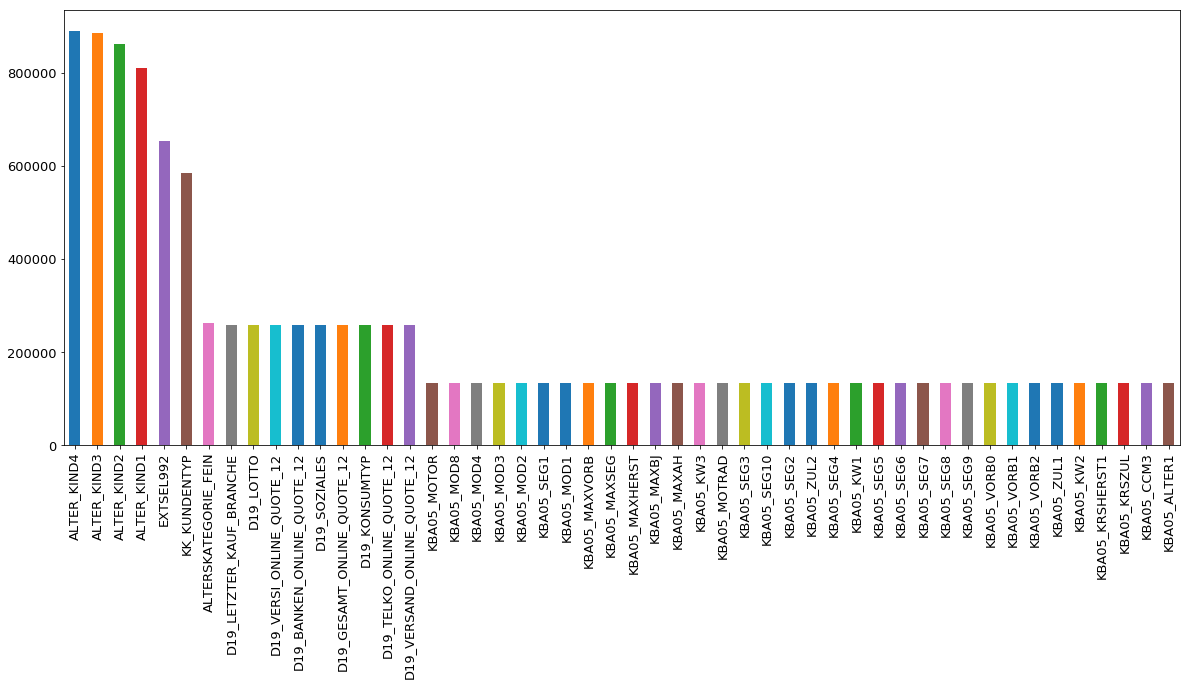

In [24]:
(azdias_null.sort_values(ascending = False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))

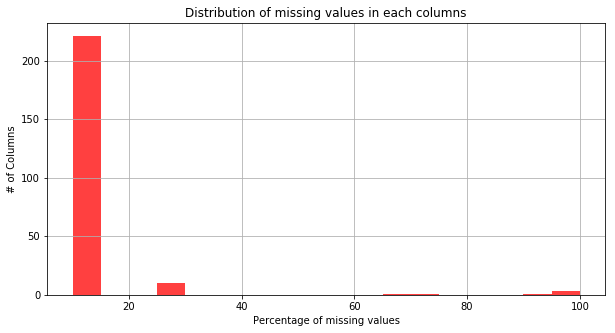

In [25]:
plt.figure(figsize=(10,5))
plt.hist(azdias_null_percentage, bins = np.linspace(10,100,19), facecolor='r', alpha = 0.75)

plt.xlabel('Percentage of missing values')
plt.ylabel('# of Columns')
plt.title('Distribution of missing values in each columns')
plt.grid(True)

plt.show()

In [26]:
print('% of missing data in columns','\n',azdias_null_percentage.sort_values(ascending=False))

% of missing data in columns 
 ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB             

Text(0,0.5,'probability of missing values')

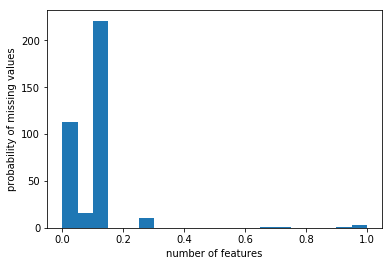

In [27]:
column_nans = azdias.isnull().mean()

plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.xlabel('number of features')
plt.ylabel('probability of missing values')

In [28]:
print('columns having  missing values >30%: ',len(azdias_null_percentage[azdias_null_percentage>30].index))
print('columns having  missing values >65%: ',len(azdias_null_percentage[azdias_null_percentage>65].index))
print('columns having  missing values >90%: ',len(azdias_null_percentage[azdias_null_percentage>90].index))

columns having  missing values >30%:  6
columns having  missing values >65%:  6
columns having  missing values >90%:  4


In [29]:
drop_cols = azdias.columns[column_nans > 0.65]
print('columns to drop: ', drop_cols)

columns to drop:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


In [30]:
#Drop columns
print('# of column in azdias before dropping: ', len(azdias.columns))
azdias = azdias.drop(drop_cols,axis=1)
print('# of column in azdias after dropping: ', len(azdias.columns))

print('# of column in customers before dropping: ', len(customers.columns))
customers = customers.drop(drop_cols,axis=1)
print('# of column in customers after dropping: ', len(customers.columns))

# of column in azdias before dropping:  366
# of column in azdias after dropping:  360
# of column in customers before dropping:  369
# of column in customers after dropping:  363


In [31]:
azdias.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=360)

In [32]:
#azdias = azdias.drop(['EINGEFUEGT_AM'],axis=1)
#customers = customers.drop(['EINGEFUEGT_AM'],axis=1)

In [ ]:
# find correlation matrix    
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias = azdias.drop(drop_columns, axis=1)
print('number of columns', len(azdias.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers = customers.drop(drop_columns, axis=1)
print('number of columns', len(customers.columns))

number of columns 241


In [ ]:
#explore object data type columns in azdias
azdias.select_dtypes(include=['object'])

In [ ]:
print('number of columns', len(azdias.columns))

In [ ]:
#explore object data type columns in customers
customers.select_dtypes(include=['object']).head()

In [ ]:
cols = azdias.columns
num_cols = azdias._get_numeric_data().columns
print('num_cols: ',num_cols)
print('categorical: ',list(set(cols) - set(num_cols)))

In [ ]:
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [ ]:
customers.isnull().sum()

In [ ]:
# fillna with 9 for fields that has 9 marked as unknown

azdias[azdias.columns[(azdias==9).any()]] = azdias[azdias.columns[(azdias==9).any()]].fillna(9)
customers[customers.columns[(customers==9).any()]] = customers[customers.columns[(customers==9).any()]].fillna(9)

In [ ]:
azdias[azdias.columns[(azdias==0).any()]] = azdias[azdias.columns[(azdias==0).any()]].fillna(0)
customers[customers.columns[(customers==0).any()]] = customers[customers.columns[(customers==0).any()]].fillna(0)

In [ ]:
# fillna with -1 for fields that has 0 marked as unknown

azdias[azdias.columns[(azdias==-1).any()]] = azdias[azdias.columns[(azdias==-1).any()]].fillna(-1)
customers[customers.columns[(customers==-1).any()]] = customers[customers.columns[(customers==-1).any()]].fillna(-1)

In [ ]:
#with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding

azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

In [ ]:
azdias_columns = azdias.columns
customers_columns = customers.columns

In [ ]:
# impute nans using mode value

imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias)
print('imputed azdias: ', azdias.head(5))

customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers)
print('imputed customers: ', customers.head(5))

In [ ]:
# convert to int
azdias = azdias.astype(int)
customers = customers.astype(int)

In [ ]:
azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

In [ ]:
azdias.to_pickle('azdias_before_scaling')
customers.to_pickle('customers_before_scaling')

In [ ]:
# load in the data
azdias = pd.read_pickle('azdias_before_scaling')
customers = pd.read_pickle('customers_before_scaling')

In [ ]:
def data_cleaning(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)
    
    
    
    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

In [ ]:
# load in the data
azdias_new = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers_new = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [ ]:
azdias_cleaned = data_cleaning(azdias_new, True, 'azdias')
print(azdias_cleaned.shape)
print(azdias_cleaned.head(5))

In [ ]:
customers_cleaned = data_cleaning(customers_new, True, 'customers')
print(customers_cleaned.shape)
print(customers_cleaned.head(5))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
%%time
pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

In [ ]:
def reduce_data(df,n=220):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [ ]:
reduced_azdias = reduce_data(azdias)
reduced_customers = reduce_data(customers)

Clustering

In [ ]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [ ]:
centers = np.linspace(1,21,21)
centers

In [ ]:
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')

In [ ]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='blue')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In [ ]:
%%time
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)

In [ ]:
azdias_clustered = pd.DataFrame(prediction_azdias, columns = ['Cluster'])

In [ ]:
prediction_customers = model_k.predict(reduced_customers)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])

Analysis of data in clusters and comparison between clusters of general population and customer data

In [ ]:
# Count number of predictions for each customer segment# Count n 
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

In [ ]:
# Create a dataframe from population and customer segments
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['population']/df_stat['population'].sum()*100)
df_stat

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [ ]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [ ]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [ ]:
# Show highest positive and negative weights for 10 cluster (over representation of Customer)
pca_weights(10,10)

In [ ]:
# Show lowest positive and negative weights for 3 cluster (under representation of Customer)
pca_weights(3,10)

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Analysis of principal components of cluster 2 with over-representation in customer segment.
CC = model_k.cluster_centers_[2]
CC = pd.Series(CC)
CC.index = CC.index +1
print(CC.sort_values(ascending=False).head(5))

# Transform cluster 2 to original feature values.
CC_inv = scale.inverse_transform(pca.inverse_transform(CC))
CC_inv = pd.Series(CC_inv).round(2)
CC_inv.index = azdias_subset_columns
CC_inv

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [ ]:
# preprocess data
df_mailout_train  = data_cleaning(X, False)

In [ ]:
df_mailout_train.shape

In [ ]:
y.shape

In [ ]:
df_mailout_train.head(5)

In [ ]:
# Split the dataset into Train/Validation/Test
X_train, X_test, y_train, y_test = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
print("X_train: " + str(X_train.shape))
print("y_train: " + str(y_train.shape))
print("X_test: " + str(X_test.shape))
print("y_test: " + str(y_test.shape))

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lr = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

In [ ]:
preds = xg_reg.predict(X_val)
preds

In [ ]:
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

Model evaluation and validation

In [ ]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    #results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # print('unique predictions_train: ', set(predictions_train))
    
    # TODO: Calculate the total prediction time
    #results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    #results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    #results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #results['prec_train'] = precision_score(y_train, predictions_train)
    #results['recall_train'] = recall_score(y_train, predictions_train)
    
    #results['prec_test'] = precision_score(y_test, predictions_test)
    #results['recall_test'] = recall_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    #results['f_train'] = fbeta_score(y_train, predictions_train, beta=1)
        
    # TODO: Compute F-score on the test set which is y_test
    #results['f_test'] = fbeta_score(y_test, predictions_test, beta=1)
       
    # Success
    #print("{} trained on samples.".format(learner.__class__.__name__))
    
    #results['roc'] = roc_auc_score(y_test, predictions_test)
    
    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc

In [ ]:
# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=42)
skf.get_n_splits(X, y)

3 Algos

In [ ]:
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)

In [ ]:
result_list = []
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        #print('Fold {}...'.format(j))
        result = {}  
        result['alg_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    
#return result_list    

print('result_list: ', result_list)

In [ ]:
df_scores = pd.DataFrame(result_list)
df_scores

In [ ]:
df_scores.groupby('alg_name')['roc'].mean()

Finetuning

In [ ]:
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[500],
                'subsample' : [0.6],
                'max_depth' : [3]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_gbr, parameters, scoring = 'roc_auc', n_jobs= -1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)

In [ ]:
roc_auc_score(y_val, best_predictions)

Find best hyperparameters

In [ ]:
alg_test = GradientBoostingRegressor(learning_rate = 0.1,
                     n_estimators = 500,
                     subsample = 0.6,
                     max_depth = 3)

In [ ]:
#from sklearn.cross_validation import KFold, StratifiedKFold

cv = StratifiedKFold(n_splits=2,shuffle=True, random_state=42)

roc_score = []
for train,test in cv.split(X_train,y_train):
    preds = alg_test.fit(X_train,y_train)
    predictions_test = preds.predict(X_val)
    roc_score.append(roc_auc_score(y_val, predictions_test))
    
print(roc_score)

Final model

In [ ]:
clf_final = GradientBoostingRegressor(learning_rate = 0.1,
                                         n_estimators = 500,
                                         subsample = 0.6,
                                         max_depth = 3)

preds = clf_final.fit(X_train,y_train)
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

In [ ]:
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[500],
                'subsample' : [0.6],
                'max_depth' : [3]
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_gbr, parameters, scoring = 'roc_auc', n_jobs= -1)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)

In [ ]:
print(roc_auc_score(y_val, best_predictions))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
# as we want to make prediction using model trained with mailout_train, check/make sure this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

In [ ]:
print('before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = data_preprocess_2(mailout_test, False)
print('after preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

In [ ]:
prediction_for_kaggle = clf_final.predict(mailout_test_clean)

In [ ]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [ ]:
df_kaggle.head(10)

In [ ]:
df_kaggle.to_csv('kaggle_submission.csv')